In [229]:
from PIL import Image
import numpy as np
import os
import pandas as pd

import glob
import argparse
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import utils

from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.pylab import rcParams

import numpy as np
import pandas as pd 
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score,mean_squared_error, mean_absolute_error, r2_score, roc_curve,auc
from sklearn.tree import DecisionTreeClassifier, plot_tree,export_graphviz
from sklearn.model_selection import train_test_split,RandomizedSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier

from scipy.stats import randint, poisson
from sklearn.preprocessing import MinMaxScaler, label_binarize

import xgboost as xgb
from xgboost import plot_tree

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate
from tensorflow.keras.models import Sequential, Model


from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta


from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from ipywidgets import interactive
from graphviz import Source
from IPython.display import SVG

import csv
import seaborn as sns
sns.set_theme()
# %matplotlib qt 

In [102]:
metadata_file = "n0_metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv"
glathida_rgis = pd.read_csv(metadata_file, low_memory=False)
print(np.unique(glathida_rgis['THICKNESS']))
np.shape(glathida_rgis)

[1.47058824e-02 1.49253731e-02 2.08333333e-02 ... 3.09633333e+03
 3.10661905e+03 3.13554545e+03]


(73111, 59)

In [231]:
# Load the data
# metadata_file = "metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv"
# glathida_rgis = pd.read_csv(metadata_file, low_memory=False)
# df3 = glathida_rgis.drop(glathida_rgis[glathida_rgis['THICKNESS'] < 0.5].index)

# print(np.shape(df3))

metadata_file = "n0_metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv"
# metadata_file = "metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv"

glathida_rgis = pd.read_csv(metadata_file, low_memory=False)

# glathida_rgis['lat'] = glathida_rgis['POINT_LAT']
glathida_rgis['v50'] = np.sqrt(glathida_rgis['vx_gf50']**2 + glathida_rgis['vy_gf50']**2)
glathida_rgis['v100'] = np.sqrt(glathida_rgis['vx_gf100']**2 + glathida_rgis['vy_gf100']**2)
glathida_rgis['v150'] = np.sqrt(glathida_rgis['vx_gf150']**2 + glathida_rgis['vy_gf150']**2)
glathida_rgis['v300'] = np.sqrt(glathida_rgis['vx_gf300']**2 + glathida_rgis['vy_gf300']**2)
glathida_rgis['v450'] = np.sqrt(glathida_rgis['vx_gf450']**2 + glathida_rgis['vy_gf450']**2)
glathida_rgis['vgfa'] = np.sqrt(glathida_rgis['vx_gfa']**2 + glathida_rgis['vy_gfa']**2)
glathida_rgis['dvx'] = np.sqrt(glathida_rgis['dvx_dx']**2 + glathida_rgis['dvx_dy']**2)

glathida_rgis['slope50'] = np.sqrt(glathida_rgis['slope_lon_gf50']**2 + glathida_rgis['slope_lat_gf50']**2)
glathida_rgis['slope100'] = np.sqrt(glathida_rgis['slope_lon_gf100']**2 + glathida_rgis['slope_lat_gf100']**2)
glathida_rgis['slope150'] = np.sqrt(glathida_rgis['slope_lon_gf150']**2 + glathida_rgis['slope_lat_gf150']**2)
glathida_rgis['slope300'] = np.sqrt(glathida_rgis['slope_lon_gf300']**2 + glathida_rgis['slope_lat_gf300']**2)
glathida_rgis['slope450'] = np.sqrt(glathida_rgis['slope_lon_gf450']**2 + glathida_rgis['slope_lat_gf450']**2)
glathida_rgis['slopegfa'] = np.sqrt(glathida_rgis['slope_lon_gfa']**2 + glathida_rgis['slope_lat_gfa']**2)
# glathida_rgis['elevation_from_zmin'] = glathida_rgis['elevation'] - glathida_rgis['Zmin']

print(np.shape(glathida_rgis))

# Group by 'RGIId' and get the unique 'Form' value for each 'RGIId'
unique_forms = glathida_rgis.groupby('RGIId')['Form'].first().reset_index()
unique_term  = glathida_rgis.groupby('RGIId')['TermType'].first().reset_index()
# Function to convert 'Form' value to 2D vector
def convert_to_2d_vector(form_value):
    return [1, 0] if form_value == 1 else [0, 1]

# Function to convert 'Termtype' value to 4D vector
def convert_to_4d_vector(term_value):
    if term_value == 0:
        return [1, 0, 0, 0]
    elif term_value == 1:
        return [0, 1, 0, 0]
    elif term_value == 2:
        return [0, 0, 1, 0]
    elif term_value == 5:
        return [0, 0, 0, 1]
    
# Apply the conversion function
unique_forms['Form_Vector'] = unique_forms['Form'].apply(convert_to_2d_vector)
form_vectors_array = np.array(unique_forms['Form_Vector'].tolist())

# Apply the conversion function
unique_term['Term_Vector'] = unique_term['TermType'].apply(convert_to_4d_vector)
term_vectors_array = np.array(unique_term['Term_Vector'].tolist())


# Display the resulting DataFrame
# print(unique_forms[['RGIId', 'Form_Vector']])
# unique_forms['Form_Vector']
# unique_term['Term_Vector']


(73111, 72)


In [174]:
def vectorize_image(image_path, threshold=128):
    """
    Reads an image and vectorizes it to 0 and 1 depending on the color.

    Parameters:
    - image_path: str, path to the image file

    Returns:
    - binary_vector: numpy array of 0s and 1s
    """
    # Open the image and convert to RGB
    image = Image.open(image_path).convert('RGB')
    
    # Convert the image to a numpy array
    image_array = np.array(image)
    
    # Define a blue color range
    lower_blue = np.array([0, 0, 128])
    upper_blue = np.array([127, 127, 255])
    
    # Create a mask for blue pixels
    blue_mask = np.all((image_array >= lower_blue) & (image_array <= upper_blue), axis=-1)
    
    # Create a binary vector where blue is 1 and everything else is 0
    binary_vector = blue_mask.astype(int)
    
    return binary_vector

In [176]:
def process_folder(folder_path):
    """
    Processes all images in the specified folder, vectorizing each one.
    
    Parameters:
    - folder_path: str, path to the folder containing images

    Returns:
    - result_dict: dictionary, keys are image filenames and values are their binary vectors
    """
    result_dict = {}
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            binary_image = vectorize_image(image_path)
            result_dict[filename] = binary_image
    
    return result_dict

In [178]:
# Example usage
folder_path = r'C:\Users\damsg\OGGM\glacier_geometries_images_small_rotmir'  
processed_images = process_folder(folder_path)

def resize_array(array, size=(64, 64)):
    # Convert the array to PIL Image
    image = Image.fromarray(np.array(array, dtype='uint8'))
    # Resize the image
    resized_image = image.resize(size, resample=Image.BILINEAR)
    # Convert the resized image back to numpy array
    return np.array(resized_image)

# Assuming 'data_dict' is your dictionary containing multiple arrays
resized_arrays = [resize_array(array) for array in processed_images.values()]

# Stack all resized arrays into a single numpy array
resized_data_array = np.stack(resized_arrays, axis=0)


## CNN

In [180]:
img_rows, img_cols = 64, 64
num_classes = 4 #Change to 2 for form to 4 for Termtype
model = Sequential()

model.add(layers.Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

model.add(layers.MaxPooling2D(pool_size=2, strides=None))

model.add(layers.Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(layers.MaxPooling2D(pool_size=2, strides=None))

model.add(layers.Conv2D(filters=128,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

model.add(layers.MaxPooling2D(pool_size=2, strides=None))

model.add(layers.Conv2D(filters=256,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(layers.MaxPooling2D(pool_size=2, strides=None))

model.add(layers.Dropout(rate=0.60))

model.add(layers.Flatten())

model.add(Dense(units=64, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 8, 8, 128)       

In [181]:
print(len(resized_data_array))
print(len(form_vectors_array))
y = [form_vectors_array[i] for i in range(len(form_vectors_array)) for _ in range(8)]
y1 = [term_vectors_array[i] for i in range(len(term_vectors_array)) for _ in range(8)]

print(len(y))
print(y[0])
X = resized_data_array

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size = 0.8, random_state=42)
X_train0, X_test0, y_train1, y_test1 = train_test_split(X, y1,train_size = 0.8, random_state=42)


18568
2321
18568
[0 1]


In [122]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])
print('--------- TRAINING ---------')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(x = np.array(X_train0), y = np.array(y_train1),validation_data=(np.array(X_test0), np.array(y_test1)), 
                    epochs = 2, callbacks=[early_stopping]) 

--------- TRAINING ---------
Epoch 1/2
465/465 [==============================] - 81s 171ms/step - loss: 1.1800 - categorical_accuracy: 0.6342 - val_loss: 0.8394 - val_categorical_accuracy: 0.8220
Epoch 2/2
465/465 [==============================] - 74s 158ms/step - loss: 0.7160 - categorical_accuracy: 0.8140 - val_loss: 0.6221 - val_categorical_accuracy: 0.8220


117/117 [==============================] - 3s 22ms/step


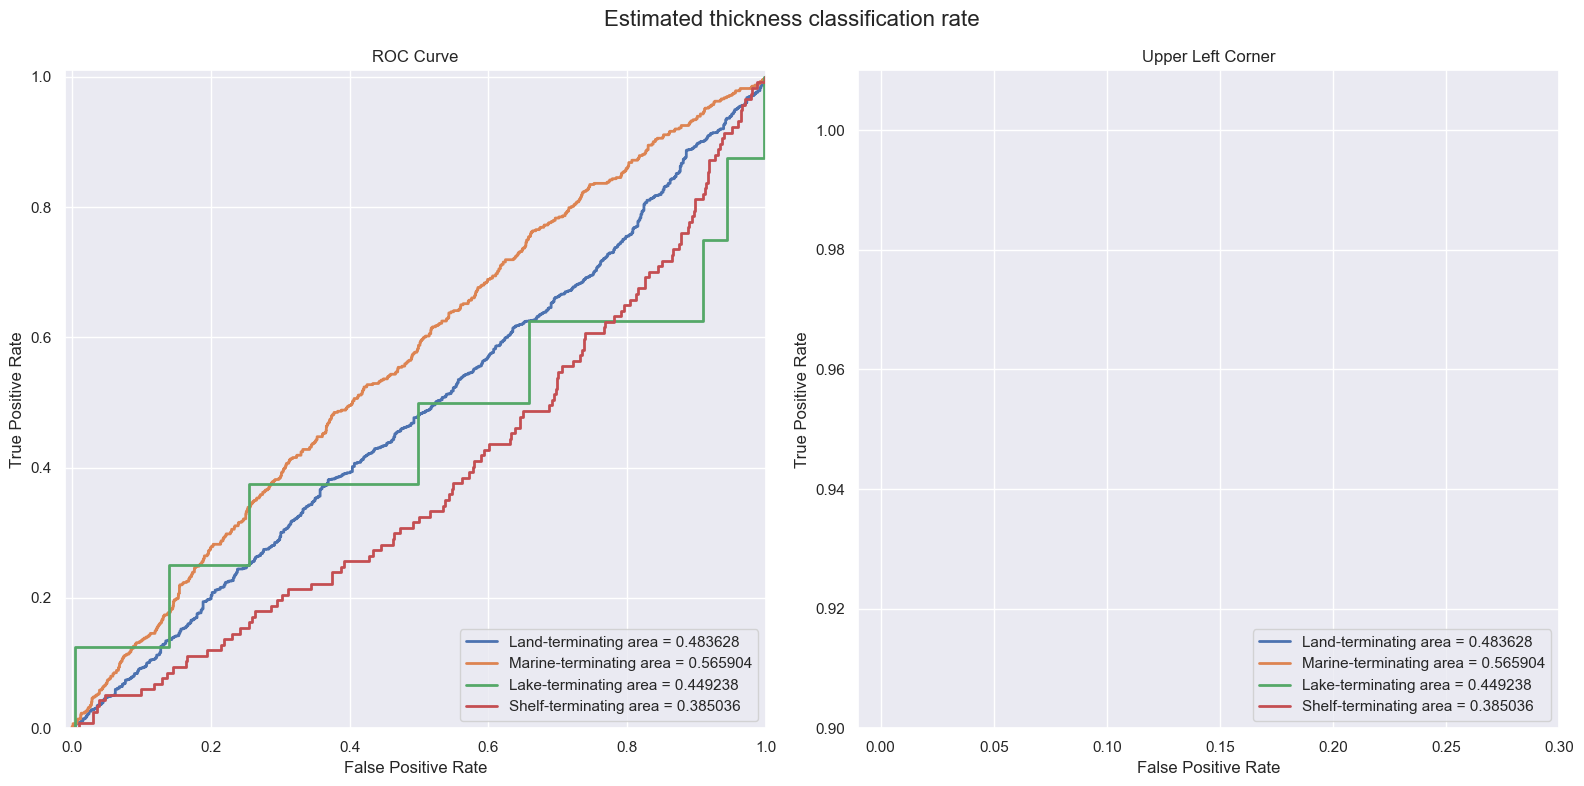

In [195]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming convert_to_4d_vector and model are already defined
def convert_to_4d_vector(term_type):
    # Example conversion function
    mapping = {
        'Land-terminating': [1, 0, 0, 0],
        'Marine-terminating': [0, 1, 0, 0],
        'Lake-terminating': [0, 0, 1, 0],
        'Shelf-terminating': [0, 0, 0, 1]
    }
    return mapping.get(term_type, [0, 0, 0, 0])

# Example dataframe
unique_term = pd.DataFrame({
    'TermType': ['Land-terminating', 'Marine-terminating', 'Lake-terminating', 'Shelf-terminating']
})

# Split the data
X_train0, X_test0, y_train1, y_test1 = train_test_split(X, y1, train_size=0.8, random_state=42)

y_probs = model.predict(X_test0)

# Get unique classes
classes = np.unique([np.argmax(vector) for vector in y_test1])
n_classes = len(classes)

# Binarize the output
y_test_binarized = label_binarize([np.argmax(vector) for vector in y_test1], classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
glacierTermTypes = ('Land-terminating', 'Marine-terminating', 'Lake-terminating', 'Shelf-terminating')
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Full ROC curve
for i in range(n_classes):
    ax[0].plot(fpr[i], tpr[i], lw=2, label=f'{glacierTermTypes[i]} area = {roc_auc[i]:.6f}')

ax[0].set_xlim([-0.01, 1.0])
ax[0].set_ylim([0.0, 1.01])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curve')
ax[0].legend(loc='lower right')

# Zoomed-in ROC curve
for i in range(n_classes):
    ax[1].plot(fpr[i], tpr[i], lw=2, label=f'{glacierTermTypes[i]} area = {roc_auc[i]:.6f}')

ax[1].set_xlim([-0.01, 0.3])
ax[1].set_ylim([0.9, 1.01])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Upper Left Corner')
ax[1].legend(loc='lower right')

fig.suptitle('Estimated thickness classification rate', size=16)

plt.tight_layout()
plt.show()
# plt.savefig('roc_class_termtype_n0.png')


## Normal NN

In [239]:
X0 = glathida_rgis.drop(['ith_m','ith_f','THICKNESS','RGIId'],axis=1) 
# X0 = glathida_rgis.drop(['Form','RGIId','ith_m','ith_f','THICKNESS'],axis=1) 
# X0 = glathida_rgis.drop(['TermType','RGIId','ith_m','ith_f','THICKNESS'],axis=1) 

scaler = MinMaxScaler()

X0 = pd.DataFrame(scaler.fit_transform(X0.values), columns=X0.columns, index=X0.index)
# y0 = glathida_rgis['Form'] 
# y0 = glathida_rgis['TermType']
y0 = glathida_rgis['THICKNESS'] 


X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0,train_size = 0.8, random_state=1)
print(np.shape(X0))
model0 = Sequential([
    Dense(72,activation='LeakyReLU'   ,name='input_layer'),
    Dense(192,activation='relu'   ,name='hidden_layer1'),
    Dense(165,activation='relu'   ,name='hidden_layer2'),
    Dense(72,activation='relu'   ,name='hidden_layer3'),
    Dense(1, name='output')])

model0.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mean_absolute_error'])

print('--------- TRAINING ---------')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model0.fit(x = np.array(X_train0), y = np.array(y_train0),validation_data=(np.array(X_test0), np.array(y_test0)), 
                    epochs = 50, callbacks=[early_stopping]) 


(73111, 68)
--------- TRAINING ---------
Epoch 1/50
1828/1828 [==============================] - 16s 7ms/step - loss: 62.2872 - mean_absolute_error: 62.2872 - val_loss: 52.9635 - val_mean_absolute_error: 52.9635
Epoch 2/50
1828/1828 [==============================] - 13s 7ms/step - loss: 53.0698 - mean_absolute_error: 53.0698 - val_loss: 50.1190 - val_mean_absolute_error: 50.1190
Epoch 3/50
1828/1828 [==============================] - 13s 7ms/step - loss: 51.2432 - mean_absolute_error: 51.2432 - val_loss: 50.2177 - val_mean_absolute_error: 50.2177
Epoch 4/50
1828/1828 [==============================] - 13s 7ms/step - loss: 50.1787 - mean_absolute_error: 50.1787 - val_loss: 49.0451 - val_mean_absolute_error: 49.0451
Epoch 5/50
1828/1828 [==============================] - 15s 8ms/step - loss: 48.7646 - mean_absolute_error: 48.7646 - val_loss: 48.3241 - val_mean_absolute_error: 48.3241
Epoch 6/50
1828/1828 [==============================] - 17s 9ms/step - loss: 47.8203 - mean_absolute_err

In [237]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess data
X0 = glathida_rgis.drop(['ith_m','ith_f','THICKNESS','RGIId'], axis=1)
scaler = MinMaxScaler()
X0 = pd.DataFrame(scaler.fit_transform(X0.values), columns=X0.columns, index=X0.index)
y0 = glathida_rgis['THICKNESS']

X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, train_size=0.8, random_state=1)

# Function to create the Keras model, required for KerasRegressor
def create_model(n_neurons1=72, n_neurons2=135, n_neurons3=165):
    model = Sequential([
        Dense(n_neurons1, activation='leaky_relu', name='input_layer'),
        Dense(n_neurons2, activation='relu', name='hidden_layer1'),
        Dense(n_neurons3, activation='relu', name='hidden_layer2'),
        Dense(56, activation='relu', name='hidden_layer3'),
        Dense(1, name='output')
    ])
    model.compile(loss='mean_absolute_error',
                  optimizer='adam',
                  metrics=['mean_absolute_error'])
    return model

# Wrap the model with KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the parameter grid
param_dist = {
    'n_neurons1': [64, 72, 80, 88, 96],
    'n_neurons2': [64, 128, 135, 160, 192],
    'n_neurons3': [96, 128, 165, 192, 224],
    'epochs': [50,60]
}

# Setup random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Setup early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit random search
random_search_result = random_search.fit(np.array(X_train0), np.array(y_train0), validation_data=(np.array(X_test0), np.array(y_test0)), callbacks=[early_stopping])

# Output the best parameters
print("Best parameters found: ", random_search_result.best_params_)
print("Best score found: ", random_search_result.best_score_)


C:\Users\damsg\AppData\Local\Temp\ipykernel_28216\2445427958.py:33: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_neurons3': 165, 'n_neurons2': 192, 'n_neurons1': 96, 'epochs': 50}
Best score found:  -36.082275390625


In [245]:
history = model0.fit(x = np.array(X_train0), y = np.array(y_train0),validation_data=(np.array(X_test0), np.array(y_test0)), 
                    epochs = 50, callbacks=[early_stopping]) 


Epoch 1/50
1828/1828 [==============================] - 22s 12ms/step - loss: 28.4705 - mean_absolute_error: 28.4705 - val_loss: 34.0492 - val_mean_absolute_error: 34.0492
Epoch 2/50
1828/1828 [==============================] - 25s 13ms/step - loss: 28.3850 - mean_absolute_error: 28.3850 - val_loss: 31.7699 - val_mean_absolute_error: 31.7699
Epoch 3/50
1828/1828 [==============================] - 27s 15ms/step - loss: 28.3400 - mean_absolute_error: 28.3400 - val_loss: 32.2281 - val_mean_absolute_error: 32.2281
Epoch 4/50
1828/1828 [==============================] - 25s 14ms/step - loss: 28.0855 - mean_absolute_error: 28.0855 - val_loss: 30.5958 - val_mean_absolute_error: 30.5958
Epoch 5/50
1828/1828 [==============================] - 26s 14ms/step - loss: 28.0307 - mean_absolute_error: 28.0307 - val_loss: 31.6400 - val_mean_absolute_error: 31.6400
Epoch 6/50
1828/1828 [==============================] - 26s 14ms/step - loss: 27.8608 - mean_absolute_error: 27.8608 - val_loss: 32.7375 - v

In [215]:
# perm_importance = permutation_importance(model0, X_test0, y_test0, scoring ='neg_mean_absolute_error', n_repeats=5, random_state=42)

feature_importance_scores = perm_importance.importances_mean

# Get feature names
feature_names = X0.columns  # Assuming X is a pandas DataFrame with feature names

# Print or visualize feature importance
sorted_feature_indices = feature_importance_scores.argsort()[::-1]
sorted_feature_names = feature_names[sorted_feature_indices]

for i, feature_name in enumerate(sorted_feature_names):
    print(f"{i+1}. {feature_name}: {feature_importance_scores[sorted_feature_indices[i]]}")


1. Zmed: 0.005709929073745945
2. Aspect: 0.004124656653926662
3. Form: 0.0032511009947928217
4. POINT_LAT: 0.0028006188892364613
5. RGI: 0.0015365256226289703
6. aspect_gfa: 0.0013626384053841202
7. aspect_300: 0.0010358497998848803
8. Zmax: 0.00052399357424735
9. smb: 0.0003666735084903561
10. aspect_50: 0.00034876667908219084
11. slope_lon_gf100: 0.00027349420798070676
12. curv_300: 0.0002556475910718836
13. slope_lon_gf300: 0.00022655289792580246
14. dist_from_border_km_geom: 0.00018556618321193818
15. slope_lon_gf450: 0.00015092586798735042
16. slope_lat: 0.00010904609561013245
17. vy_gf150: 0.00010066974887859014
18. vx_gf150: 5.431998820853989e-05
19. vx_gf300: 2.8750925930309813e-05
20. curv_50: 2.5984332648920637e-05
21. vy: 1.5212649709073211e-05
22. vy_gf300: 1.2787207047448845e-05
23. vy_gf100: 1.0764569195886864e-05
24. vx_gfa: 3.74171580541649e-06
25. vy_gf50: -1.527155426273019e-06
26. dvx_dy: -3.333697056728813e-06
27. dvy_dy: -8.650500142592943e-06
28. dvy_dx: -1.224542

# Combine CNN with NN

## Form CNN + NN

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate
num_features = 67 #Features in dataset
# Define input layers for both image and non-image data
image_input = Input(shape=(64, 64, 1))  # Assuming 64x64 RGB images
non_image_input = Input(shape=(num_features,))  # Specify the number of features for your non-image data

# CNN for image data
conv1 = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = layers.Conv2D(256, (3, 3), activation='relu')(pool3)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
flatten = layers.Flatten()(pool4)

# Add the dense layer with 64 units and ReLU activation
dense_64_relu = Dense(64, activation='relu')(flatten)

# Concatenate the dense layer output with non-image data
combined_input = concatenate([dense_64_relu, non_image_input])

# Fully connected layers for combined data
fc1 = Dense(64 + num_features, activation='relu')(combined_input)
fc2 = Dense(180, activation='relu')(fc1)
fc3 = Dense(180, activation='relu')(fc2)
fc3 = Dense(32, activation='relu')(fc2)
output = Dense(1, activation='sigmoid')(fc3)  # Output layer for binary classification

# Define the combined model
combined_model = Model(inputs=[image_input, non_image_input], outputs=output)

# Compile the model
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
combined_model.summary()


# history = combined_model.fit(inputs = [resized_data_array,]) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 62, 62, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 31, 31, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 29, 29, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

In [197]:
# Example usage
folder_path = r'C:\Users\damsg\OGGM\glacier_geometries_images_small'  
processed_images = process_folder(folder_path)

def resize_array(array, size=(64, 64)):
    # Convert the array to PIL Image
    image = Image.fromarray(np.array(array, dtype='uint8'))
    # Resize the image
    resized_image = image.resize(size, resample=Image.BILINEAR)
    # Convert the resized image back to numpy array
    return np.array(resized_image)

# Assuming 'data_dict' is your dictionary containing multiple arrays
resized_arrays = [resize_array(array) for array in processed_images.values()]

# Stack all resized arrays into a single numpy array
resized_data_array = np.stack(resized_arrays, axis=0)

# Apply the conversion function
unique_forms = glathida_rgis.groupby('RGIId')['Form'].first().reset_index()
unique_forms['Form_Vector'] = unique_forms['Form'].apply(convert_to_2d_vector)
form_vectors_array = np.array(unique_forms['Form_Vector'].tolist())

# Apply the conversion function
unique_term  = glathida_rgis.groupby('RGIId')['TermType'].first().reset_index()
unique_term['Term_Vector'] = unique_term['TermType'].apply(convert_to_4d_vector)
term_vectors_array = np.array(unique_term['Term_Vector'].tolist())

In [198]:
folder_path = r'C:\Users\damsg\OGGM\glacier_geometries_images_small'  
processed_images = process_folder(folder_path)

# n0_metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv
# metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv

def resize_array(array, size=(64, 64)):
    # Convert the array to PIL Image
    image = Image.fromarray(np.array(array, dtype='uint8'))
    # Resize the image
    resized_image = image.resize(size, resample=Image.BILINEAR)
    return np.array(resized_image)

resized_arrays = [resize_array(array) for array in processed_images.values()]

# Stack all resized arrays into a single numpy array
resized_data_array = np.stack(resized_arrays, axis=0)

pictures = []
current_rgi_id = None
i = -1  # Initial value of i

for rgi_id in glathida_rgis['RGIId']:
    if rgi_id != current_rgi_id:
        i += 1  # Increment i when RGIId changes
        current_rgi_id = rgi_id
    pictures.append(resized_data_array[i])

# Convert pictures to a numpy array if needed
pictures = np.array(pictures)
print(np.shape(pictures))
print(np.shape(glathida_rgis['RGIId']))

(81290, 64, 64)
(81290,)


In [204]:
%%time
# Load the metadata files
metadata19 = pd.read_csv('metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv')
n0_metadata19 = pd.read_csv('n0_metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv')

# Get the list of RGIId from both metadata files
metadata19_rgi_ids = metadata19['RGIId'].tolist()
n0_rgi_ids = n0_metadata19['RGIId'].tolist()
metadata19_rgi_ids = np.unique(metadata19_rgi_ids)
# Assuming images are in the same order as metadata19
images = resized_data_array
print(len(np.unique(metadata19_rgi_ids)))
print(len(np.unique(n0_metadata19['RGIId'])))
print(len(resized_data_array))

pictures = []
ind = 0
for i in range(len(metadata19_rgi_ids)):
    for j in range(len(n0_rgi_ids)):
        if metadata19_rgi_ids[i] == n0_rgi_ids[j]:
            pictures.append(images[i])
print(len(pictures)) 


2321
2101
2321
73111
CPU times: total: 1min 34s
Wall time: 1min 43s


In [210]:
# pictures = resized_data_array
pictures = np.array(pictures)

y01 = glathida_rgis['Form'] 
y02_values = glathida_rgis['TermType']

y02 = np.array([convert_to_4d_vector(term_value) for term_value in y02_values])
# y02_one_hot = [convert_to_4d_vector(term_value) for term_value in y02_values]

# Convert the list to a numpy array if needed
# y02 = np.array(y02_one_hot)


y03 = glathida_rgis['THICKNESS']

X01 = glathida_rgis.drop(['Form','RGIId','ith_m','ith_f','THICKNESS'],axis=1) 
X02 = glathida_rgis.drop(['TermType','RGIId','ith_m','ith_f','THICKNESS'],axis=1) 
X03 = glathida_rgis.drop(['RGIId','ith_m','ith_f','THICKNESS'],axis=1) 
print(np.shape(X03))
scaler = MinMaxScaler()

X01 = pd.DataFrame(scaler.fit_transform(X01.values), columns=X01.columns, index=X01.index)
X02 = pd.DataFrame(scaler.fit_transform(X02.values), columns=X02.columns, index=X02.index)
X03 = pd.DataFrame(scaler.fit_transform(X03.values), columns=X03.columns, index=X03.index)

unique_forms = glathida_rgis.groupby('RGIId')['Form'].first().reset_index()
unique_term  = glathida_rgis.groupby('RGIId')['TermType'].first().reset_index()

X01_train, X01_test, y01_train, y01_test = train_test_split(X01, y01,train_size = 0.8, random_state=42)
X02_train, X02_test, y02_train, y02_test = train_test_split(X02, y02,train_size = 0.8, random_state=42)
X03_train, X03_test, y03_train, y03_test = train_test_split(X03, y03,train_size = 0.8, random_state=42)
#Shooting for form
pictures_train, pictures_val, X01_train, X01_val, y01_train, y01_val = train_test_split(
    pictures, X01, y01, test_size=0.2, random_state=42)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=2,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)
checkpoint = ModelCheckpoint(
    r'C:/Users/damsg/Desktop/Python/AppliedMachineLearning/Final_Project_Glacier/Form_model_weights_n0.h5',  # Full file path to save the model weights
    monitor='val_loss',               # Metric to monitor
    save_best_only=True,              # Save only the best weights
    save_weights_only=True            # Save only the weights (not the entire model)
)

# combined_model.fit(
#     [pictures_train, X01_train],  # Inputs: list of image data and non-image data
#     y01_train,                    # Target labels
#     epochs=7,                    # Number of epochs
#     batch_size=32,                # Batch size
#     validation_data=([pictures_val, X01_val], y01_val),  # Validation data
#     callbacks=[early_stopping,checkpoint]    # Include the early stopping callback
# )
combined_model.save_weights(r'C:/Users/damsg/Desktop/Python/AppliedMachineLearning/Final_Project_Glacier/Form_model_weights_final_n0.h5')

(73111, 68)


## Termtype CNN + NN

In [216]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate
num_features = 67 #Features in dataset
# Define input layers for both image and non-image data
image_input = Input(shape=(64, 64, 1))  # Assuming 64x64 Greyscale images
non_image_input = Input(shape=(num_features,))  # Specify the number of features for your non-image data

# CNN for image data
conv1 = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = layers.Conv2D(256, (3, 3), activation='relu')(pool3)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
flatten = layers.Flatten()(pool4)

# Add the dense layer with 64 units and ReLU activation
dense_64_relu = Dense(64, activation='relu')(flatten)

# Concatenate the dense layer output with non-image data
combined_input = concatenate([dense_64_relu, non_image_input])

# Fully connected layers for combined data
fc1 = Dense(64 + num_features, activation='relu')(combined_input)
fc2 = Dense(200, activation='relu')(fc1)
fc3 = Dense(220, activation='relu')(fc2)
fc3 = Dense(32, activation='relu')(fc2)
output = Dense(4, activation='sigmoid')(fc3)  # Output layer for multi classification

# Define the combined model
combined_model = Model(inputs=[image_input, non_image_input], outputs=output)

# Compile the model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
combined_model.summary()


# history = combined_model.fit(inputs = [resized_data_array,]) 

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_52 (Conv2D)             (None, 62, 62, 32)   320         ['input_14[0][0]']               
                                                                                                  
 max_pooling2d_52 (MaxPooling2D  (None, 31, 31, 32)  0           ['conv2d_52[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_53 (Conv2D)             (None, 29, 29, 64)   18496       ['max_pooling2d_52[0][0]']

In [218]:
#Shooting for TermType
pictures_train, pictures_val, X02_train, X02_val, y02_train, y02_val = train_test_split(
    pictures, X02, y02, test_size=0.2, random_state=42)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)

checkpoint = ModelCheckpoint(
    r'C:/Users/damsg/Desktop/Python/AppliedMachineLearning/Final_Project_Glacier/Term_model_weights_n0.h5',  # Full file path to save the model weights
    monitor='val_loss',               # Metric to monitor
    save_best_only=True,              # Save only the best weights
    save_weights_only=True            # Save only the weights (not the entire model)
)
# Train the model with early stopping
combined_model.fit(
    [pictures_train, X02_train],  # Inputs: list of image data and non-image data
    y02_train,                    # Target labels
    epochs=7,                    # Number of epochs
    batch_size=32,                # Batch size
    validation_data=([pictures_val, X02_val], y02_val),  # Validation data
    callbacks=[early_stopping,checkpoint]    # Include the early stopping callback
)

combined_model.save_weights(r'C:/Users/damsg/Desktop/Python/AppliedMachineLearning/Final_Project_Glacier/Term_model_weights_final_n0.h5')

Epoch 1/7
1828/1828 [==============================] - 286s 156ms/step - loss: 0.2086 - accuracy: 0.9207 - val_loss: 0.0879 - val_accuracy: 0.9714
Epoch 2/7
1828/1828 [==============================] - 295s 161ms/step - loss: 0.0672 - accuracy: 0.9768 - val_loss: 0.0520 - val_accuracy: 0.9816
Epoch 3/7
1828/1828 [==============================] - 305s 167ms/step - loss: 0.0430 - accuracy: 0.9852 - val_loss: 0.0490 - val_accuracy: 0.9842
Epoch 4/7
1828/1828 [==============================] - 305s 167ms/step - loss: 0.0334 - accuracy: 0.9881 - val_loss: 0.0287 - val_accuracy: 0.9919
Epoch 5/7
1828/1828 [==============================] - 299s 164ms/step - loss: 0.0252 - accuracy: 0.9910 - val_loss: 0.0304 - val_accuracy: 0.9909
Epoch 6/7
1828/1828 [==============================] - 305s 167ms/step - loss: 0.0244 - accuracy: 0.9916 - val_loss: 0.0281 - val_accuracy: 0.9919
Epoch 7/7
1828/1828 [==============================] - 305s 167ms/step - loss: 0.0221 - accuracy: 0.9925 - val_loss: 0

457/457 [==============================] - 13s 29ms/step


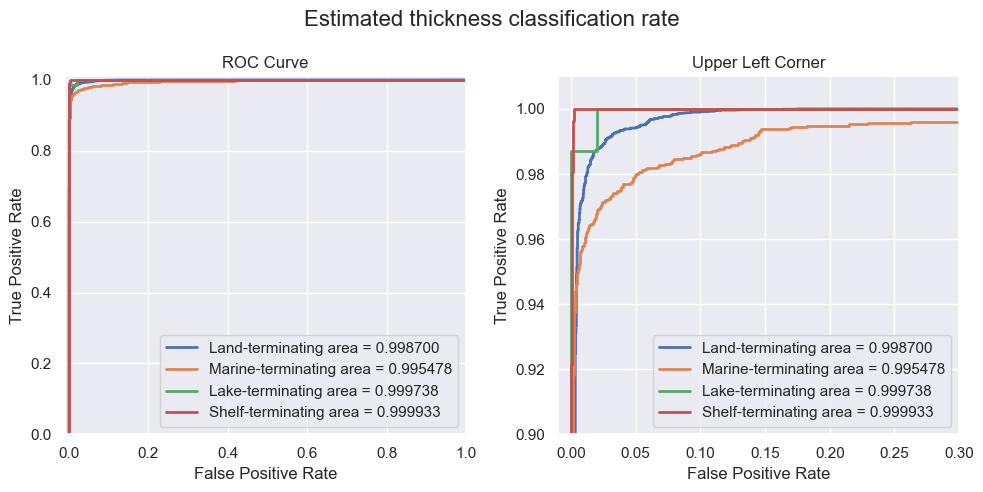

In [227]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming convert_to_4d_vector and model are already defined
def convert_to_4d_vector(term_type):
    # Example conversion function
    mapping = {
        'Land-terminating': [1, 0, 0, 0],
        'Marine-terminating': [0, 1, 0, 0],
        'Lake-terminating': [0, 0, 1, 0],
        'Shelf-terminating': [0, 0, 0, 1]
    }
    return mapping.get(term_type, [0, 0, 0, 0])

# Example dataframe
unique_term = pd.DataFrame({
    'TermType': ['Land-terminating', 'Marine-terminating', 'Lake-terminating', 'Shelf-terminating']
})

# Split the data
pictures_train, pictures_val, X02_train, X02_val, y02_train, y02_val = train_test_split(
    pictures, X02, y02, test_size=0.2, random_state=42)

y_probs = combined_model.predict([pictures_val,X02_val])

# Get unique classes
classes = np.unique([np.argmax(vector) for vector in y02_val])
n_classes = len(classes)

# Binarize the output
y_test_binarized = label_binarize([np.argmax(vector) for vector in y02_val], classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
glacierTermTypes = ('Land-terminating', 'Marine-terminating', 'Lake-terminating', 'Shelf-terminating')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Full ROC curve
for i in range(n_classes):
    ax[0].plot(fpr[i], tpr[i], lw=2, label=f'{glacierTermTypes[i]} area = {roc_auc[i]:.6f}')

ax[0].set_xlim([-0.01, 1.0])
ax[0].set_ylim([0.0, 1.01])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curve')
ax[0].legend(loc='lower right')

# Zoomed-in ROC curve
for i in range(n_classes):
    ax[1].plot(fpr[i], tpr[i], lw=2, label=f'{glacierTermTypes[i]} area = {roc_auc[i]:.6f}')

ax[1].set_xlim([-0.01, 0.3])
ax[1].set_ylim([0.9, 1.01])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Upper Left Corner')
ax[1].legend(loc='lower right')

fig.suptitle('Estimated thickness classification rate', size=16)

plt.tight_layout()
plt.show()
# plt.savefig('roc_class_termtype_n0.png')


## Thickness CNN + NN

In [261]:
num_features = 68 #Features in dataset
print(np.shape(glathida_rgis))
# Define input layers for both image and non-image data
image_input = Input(shape=(64, 64, 1))  # Assuming 64x64 RGB images
non_image_input = Input(shape=(num_features,))  # Specify the number of features for your non-image data

# CNN for image data
conv1 = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = layers.Conv2D(256, (3, 3), activation='relu')(pool3)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
flatten = layers.Flatten()(pool4)

# Add the dense layer with 64 units and ReLU activation
dense_64_relu = Dense(64, activation='relu')(flatten)

# Concatenate the dense layer output with non-image data
combined_input = concatenate([dense_64_relu, non_image_input])

# Fully connected layers for combined data
fc1 = Dense(64 + num_features, activation='relu')(combined_input)
fc2 = Dense(145, activation='relu')(fc1)
fc3 = Dense(175, activation='relu')(fc2)
fc3 = Dense(96, activation='relu')(fc2)
output = Dense(1)(fc3)  # Output layer for regression

# Define the combined model
combined_model = Model(inputs=[image_input, non_image_input], outputs=output)

# Compile the model
combined_model.compile(optimizer='adam',loss= 'mean_absolute_error',metrics=['mean_absolute_error'])
# Print the model summary
combined_model.summary()

(73111, 72)
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_56 (Conv2D)             (None, 62, 62, 32)   320         ['input_16[0][0]']               
                                                                                                  
 max_pooling2d_56 (MaxPooling2D  (None, 31, 31, 32)  0           ['conv2d_56[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 29, 29, 64)   18496       ['max_pooling2

In [312]:
#Shooting for Thickness
pictures_train, pictures_val, X03_train, X03_val, y03_train, y03_val = train_test_split(
    pictures, X03, y03, test_size=0.2, random_state=42)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=8,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)
checkpoint = ModelCheckpoint(
    r'C:/Users/damsg/Desktop/Python/AppliedMachineLearning/Final_Project_Glacier/Thick_model_weights_n0.h5',  # Full file path to save the model weights
    monitor='val_loss',               # Metric to monitor
    save_best_only=True,              # Save only the best weights
    save_weights_only=True            # Save only the weights (not the entire model)
)

# Train the model with early stopping
combined_model.fit(
    [pictures_train, X03_train],  # Inputs: list of image data and non-image data
    y03_train,                    # Target labels
    epochs=50,                   # Number of epochs
    batch_size=32,                # Batch size
    validation_data=([pictures_val, X03_val], y03_val),  # Validation data
    callbacks=[early_stopping,checkpoint]    # Include the early stopping callback
)

combined_model.save_weights(r'C:/Users/damsg/Desktop/Python/AppliedMachineLearning/Final_Project_Glacier/Thick_model_weights_final_n0.h5')


Epoch 1/50
1828/1828 [==============================] - 167s 92ms/step - loss: 24.7428 - mean_absolute_error: 24.7428 - val_loss: 28.5411 - val_mean_absolute_error: 28.5411
Epoch 2/50
1828/1828 [==============================] - 171s 94ms/step - loss: 24.6220 - mean_absolute_error: 24.6220 - val_loss: 29.1104 - val_mean_absolute_error: 29.1104
Epoch 3/50
1828/1828 [==============================] - 169s 92ms/step - loss: 24.5900 - mean_absolute_error: 24.5900 - val_loss: 28.4432 - val_mean_absolute_error: 28.4432
Epoch 4/50
1828/1828 [==============================] - 170s 93ms/step - loss: 24.6215 - mean_absolute_error: 24.6215 - val_loss: 29.5817 - val_mean_absolute_error: 29.5817
Epoch 5/50
1828/1828 [==============================] - 162s 89ms/step - loss: 24.4717 - mean_absolute_error: 24.4717 - val_loss: 27.7941 - val_mean_absolute_error: 27.7941
Epoch 6/50
1828/1828 [==============================] - 164s 89ms/step - loss: 24.3767 - mean_absolute_error: 24.3767 - val_loss: 28.91

In [321]:
# y_preds = combined_model.predict([pictures_val, X03_val])
# evaluation_plot(combined_model,y03_val, y_preds)
print(y_preds)
print(len(y03_val))

[[200.3994  ]
 [221.37292 ]
 [177.01059 ]
 ...
 [ 77.300995]
 [ 35.623062]
 [315.00327 ]]
14623


457/457 [==============================] - 21s 45ms/step


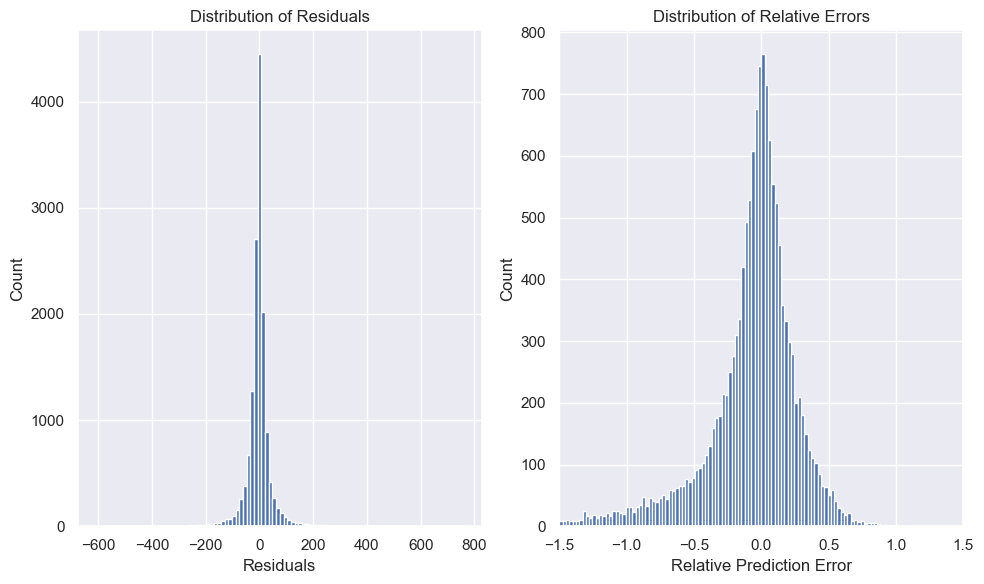

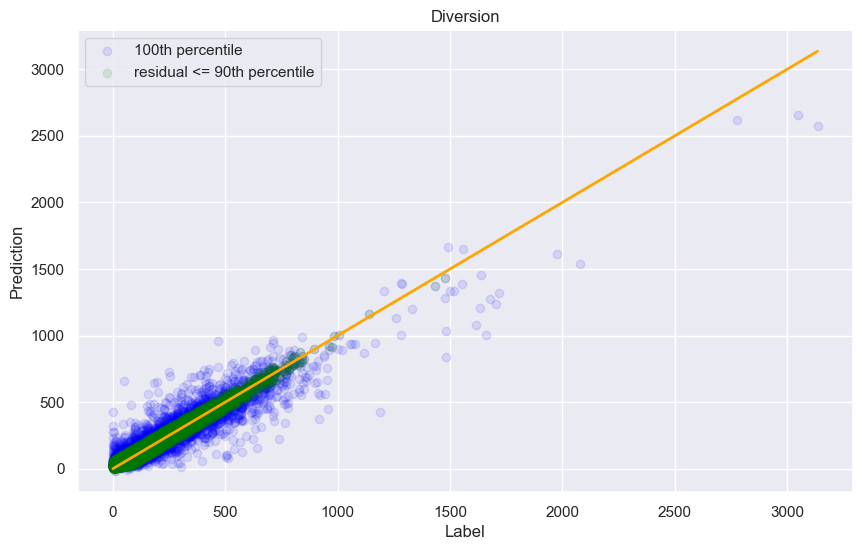

In [263]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluation_plot1(model,pictures , X_test, y_test):
    # Predict on the test set
    y_pred = model.predict([pictures, X03_val])
    
    # Flatten the predictions if needed
    if len(y_pred.shape) > 1 and y_pred.shape[1] == 1:
        y_pred = y_pred.flatten()
        
    # Convert y_test to numpy array
    y_test = np.array(y_test)
    
    # Calculate residuals and relative errors
    residuals = y_test - y_pred
    relative_errors = residuals / np.abs(y_test)
    relative_errors = relative_errors[np.abs(relative_errors) <= 1.5]
    percentile_90 = np.percentile(np.abs(residuals), 90)
    high_residual_mask = np.abs(residuals) <= percentile_90
    
    # Plot the Distribution of the Residuals and the Relative Errors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    ax1.hist(residuals, bins=100)
    ax1.set_title('Distribution of Residuals')
    ax1.set_xlabel('Residuals')
    ax1.set_ylabel('Count')
    
    ax2.hist(relative_errors, bins='auto')
    ax2.set_title('Distribution of Relative Errors')
    ax2.set_xlabel('Relative Prediction Error')
    ax2.set_ylabel('Count')
    ax2.set_xlim(-1.5, 1.5)
    plt.tight_layout()
    plt.show()
    
    # Plot the Diversion
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, c='blue', alpha=0.1, label='100th percentile')
    plt.scatter(y_test[high_residual_mask], y_pred[high_residual_mask], c='green', alpha=0.1, label='residual <= 90th percentile')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linewidth=2)
    plt.xlabel('Label')
    plt.ylabel('Prediction')
    plt.title('Diversion')
    plt.legend()
    plt.show()

# Usage example:
# Assuming you have a trained model and test data (X_test, y_test)
# model = ... # Your trained TensorFlow/Keras model
# X_test, y_test = ... # Your test data
combined_model.load_weights(r'C:/Users/damsg/Desktop/Python/AppliedMachineLearning/Final_Project_Glacier/Thick_model_weights_final_n0_27_4.h5')

evaluation_plot1(combined_model,pictures_val, X03_val, y03_val)


In [ ]:
#combined_model.load_weights('r'C:/Users/damsg/Desktop/Python/AppliedMachineLearning/Final_Project_Glacier/model_weights_final.h5'')


In [88]:
# print(np.shape(pictures))
# print(np.shape(glathida_rgis))

## LIGHTGBM + CNN
### (For Luisa) Change LGBM to XGB here :) 

In [26]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model, layers
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping

# Split the data into training and validation sets
pictures_train, pictures_val, X03_train, X03_val, y03_train, y03_val = train_test_split(
    pictures, X03, y03, test_size=0.2, random_state=42)

num_features = X03.shape[1]  # Number of non-image features

# Define the CNN model for feature extraction
image_input = Input(shape=(64, 64, 1))  # Assuming 64x64 grayscale images

conv1 = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = layers.Conv2D(256, (3, 3), activation='relu')(pool3)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
flatten = layers.Flatten()(pool4)

# Define the model to output the flattened features
feature_extraction_model = Model(inputs=image_input, outputs=flatten)
feature_extraction_model.summary()

# Extract features from the training and validation image data
image_features_train = feature_extraction_model.predict(pictures_train)
image_features_val = feature_extraction_model.predict(pictures_val)

# Combine image features with non-image data
combined_train_data = np.concatenate([image_features_train, X03_train], axis=1)
combined_val_data = np.concatenate([image_features_val, X03_val], axis=1)

# Create LightGBM datasets for training and validation
train_data = lgb.Dataset(combined_train_data, label=y03_train)
val_data = lgb.Dataset(combined_val_data, label=y03_val, reference=train_data)

# Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model with early stopping
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=5000,
    valid_sets=[train_data, val_data],
    callbacks=[early_stopping(stopping_rounds=5)]
)

# Make predictions on the validation set
predictions_val = gbm.predict(combined_val_data)

# Evaluate the model (example: Mean Absolute Error)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y03_val, predictions_val)
print(f'Mean Absolute Error on validation set: {mae}')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       7385

In [376]:
# import numpy as np
# import lightgbm as lgb
# from lightgbm import LGBMRegressor
# from sklearn.metrics import mean_absolute_error
# from sklearn.model_selection import cross_val_score, train_test_split
# from tensorflow.keras import Input, Model, layers

# # Split the data into training and validation sets
# pictures_train, pictures_val, X03_train, X03_val, y03_train, y03_val = train_test_split(
#     pictures, X03, y03, test_size=0.2, random_state=42)

# num_features = X03.shape[1]  # Number of non-image features

# # Define the CNN model for feature extraction
# image_input = Input(shape=(64, 64, 1))  # Assuming 64x64 grayscale images

# conv1 = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
# pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
# conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
# pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
# conv3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
# pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
# conv4 = layers.Conv2D(256, (3, 3), activation='relu')(pool3)
# pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
# flatten = layers.Flatten()(pool4)

# # Define the model to output the flattened features
# feature_extraction_model = Model(inputs=image_input, outputs=flatten)
# feature_extraction_model.summary()

# # Extract features from the training and validation image data
# image_features_train = feature_extraction_model.predict(pictures_train)
# image_features_val = feature_extraction_model.predict(pictures_val)

# # Combine image features with non-image data
# combined_train_data = np.concatenate([image_features_train, X03_train], axis=1)
# combined_val_data = np.concatenate([image_features_val, X03_val], axis=1)

# # Train the LightGBM model with early stopping
# gbm = LGBMRegressor(
#     objective='regression',
#     metric='mae',
#     boosting_type='gbdt',
#     num_leaves=31,
#     learning_rate=0.05,
#     feature_fraction=0.9,
#     n_estimators=5000
# )

# # Fit the model with early stopping on validation data
# gbm.fit(
#     combined_train_data, y03_train,
#     eval_set=[(combined_val_data, y03_val)],
#     eval_metric='mae',
#     # early_stopping_rounds=5
# )

# # Make predictions on the validation set
# predictions_val = gbm.predict(combined_val_data)

# # Evaluate the model (example: Mean Absolute Error)
# mae = mean_absolute_error(y03_val, predictions_val)
# print(f'Mean Absolute Error on validation set: {mae}')

# # Perform cross-validation
# combined_data = np.concatenate([feature_extraction_model.predict(pictures), X03], axis=1)
# cv_scores = cross_val_score(gbm, combined_data, y03, cv=5, scoring='neg_mean_absolute_error')

# print("Cross-Validation: %.4f +- %.4f" % (-cv_scores.mean(), cv_scores.std()))


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_80 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 12, 12, 128)       738

In [378]:
(glathida_rgis2['PICTURE'][0][2])
cv_scores

array([-94.10028608, -70.40271508, -42.55646754, -34.27147357,
       -47.89710485])

In [90]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model, layers
import numpy as np
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split the data into training and validation sets
pictures_train, pictures_val, X03_train, X03_val, y03_train, y03_val = train_test_split(
    pictures, X03, y03, test_size=0.2, random_state=42)

num_features = X03.shape[1]  # Number of non-image features

# Define the CNN model for feature extraction
image_input = Input(shape=(64, 64, 1))  # Assuming 64x64 grayscale images

conv1 = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = layers.Conv2D(256, (3, 3), activation='relu')(pool3)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
flatten = layers.Flatten()(pool4)

# Define the model to output the flattened features
feature_extraction_model = Model(inputs=image_input, outputs=flatten)
# feature_extraction_model.summary()

# Extract features from the training and validation image data
image_features_train = feature_extraction_model.predict(pictures_train)
image_features_val = feature_extraction_model.predict(pictures_val)

# Combine image features with non-image data
combined_train_data = np.concatenate([image_features_train, X03_train], axis=1)
combined_val_data = np.concatenate([image_features_val, X03_val], axis=1)

# The objective function for Optuna
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 0.5, 100.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 50.0),
        'num_leaves': trial.suggest_int('num_leaves', 96, 2048),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.70, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 2, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 25)
    }

    # run the model, fit and predict 
    model = lgb.LGBMRegressor(**param)

    # Fit model
    model.fit(
        combined_train_data, y03_train,
        eval_set=[(combined_val_data, y03_val)],
        eval_metric='mae',
        callbacks=[LightGBMPruningCallback(trial, 'l1')]
    )
    
    y_preds = model.predict(combined_val_data)
    
    mae = mean_absolute_error(y03_val, y_preds)
    
    return mae


study = optuna.create_study(direction='minimize')

initial_params = [
    {'lambda_l1': 43.717089120026756, 'lambda_l2': 6.587549445785165, 'num_leaves': 1922, 'feature_fraction': 0.668370377660226,
     'bagging_fraction': 0.8886019976321862, 'bagging_freq': 1, 'min_child_samples': 16},
    {'lambda_l1': 0.10945207477477581, 'lambda_l2': 9.03876231037474, 'num_leaves': 1961, 'feature_fraction': 0.780528052763212,
     'bagging_fraction': 0.9480446922239267, 'bagging_freq': 7, 'min_child_samples': 16}
]

for params in initial_params:
    study.enqueue_trial(params)

# Create a study and start the optimization process
study.optimize(objective, n_trials=150)

# Print the best parameters
print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


457/457 [==============================] - 8s 17ms/step


[I 2024-06-08 22:18:32,027] A new study created in memory with name: no-name-3eae806c-9ccd-47b2-a805-e2ac8282fb65
C:\Users\damsg\anaconda3\envs\MLenv\lib\site-packages\optuna\trial\_trial.py:650: UserWarning: Fixed parameter 'bagging_freq' with value 1 is out of range for distribution IntDistribution(high=10, log=False, low=2, step=1).
  warnings.warn(
[I 2024-06-08 22:20:40,364] Trial 0 finished with value: 20.830399354031684 and parameters: {'lambda_l1': 43.717089120026756, 'lambda_l2': 6.587549445785165, 'num_leaves': 1922, 'feature_fraction': 0.668370377660226, 'bagging_fraction': 0.8886019976321862, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 0 with value: 20.830399354031684.
C:\Users\damsg\anaconda3\envs\MLenv\lib\site-packages\optuna\trial\_trial.py:650: UserWarning: Fixed parameter 'lambda_l1' with value 0.10945207477477581 is out of range for distribution FloatDistribution(high=100.0, log=False, low=0.5, step=None).
  warnings.warn(
[I 2024-06-08 22:23:48,356] T

Best trial:
  Value: 20.27475859059616
  Params: 
    lambda_l1: 3.6018619654574158
    lambda_l2: 6.8313158663780085
    num_leaves: 1949
    feature_fraction: 0.7141755393339907
    bagging_fraction: 0.9475392738527537
    bagging_freq: 7
    min_child_samples: 7


Best trial:
  Value: 20.656476474109315
  Params: 
    lambda_l1: 43.717089120026756
    lambda_l2: 6.587549445785165
    num_leaves: 1922
    feature_fraction: 0.668370377660226
    bagging_fraction: 0.8886019976321862
    bagging_freq: 1
    min_child_samples: 16
Best trial:
  Value: 20.145705597469057
  Params: 
    lambda_l1: 0.10945207477477581
    lambda_l2: 9.03876231037474
    num_leaves: 1961
    feature_fraction: 0.780528052763212
    bagging_fraction: 0.9480446922239267
    bagging_freq: 7
    min_child_samples: 16
















1st try
Best trial:
  Value: 21.53931570838462
  Params: 
    lambda_l1: 2.01546274100036
    lambda_l2: 0.7111412857087858
    num_leaves: 242
    feature_fraction: 0.6227918411296163
    bagging_fraction: 0.9655103122297912
    bagging_freq: 7
    min_child_samples: 27

2nd try Increased the parameter space notably 
num leaves (2,256) -> (128,1024)
min_clild_samples (5,100) -> (10,250)
Best trial:
  Value: 19.440244621935555
  Params: 
    lambda_l1: 9.942178625506006
    lambda_l2: 6.021388788503392
    num_leaves: 927
    feature_fraction: 0.7971447195854893
    bagging_fraction: 0.9630138347471484
    bagging_freq: 5
    min_child_samples: 25
    
3nd try Increased the parameter space notably 
num leaves             (2,256) -> (128,2048)
'lambda_l1':           (1e-8, 10.0) -> (1e-8, 50.0)
'lambda_l2':           (1e-8, 10.0) -> (1e-8, 50.0)
feature_fraction':     (0.4, 1.0) -> (0.5, 0.9)
Best trial:
  Value: 18.961424118310052
  Params: 
    lambda_l1: 48.11818528734888
    lambda_l2: 6.7716539555661415
    num_leaves: 1892
    feature_fraction: 0.6871792889443591
    bagging_fraction: 0.9856255101027098
    bagging_freq: 1
    min_child_samples: 14

4th try Increased the parameter space notably 
'rmse' -> mae

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[326]	valid_0's l1: 19.7834
Mean Absolute Error: 19.783395654017966
Root Mean Squared Error: 39.58443579088508
R^2 Score: 0.9483174213354257


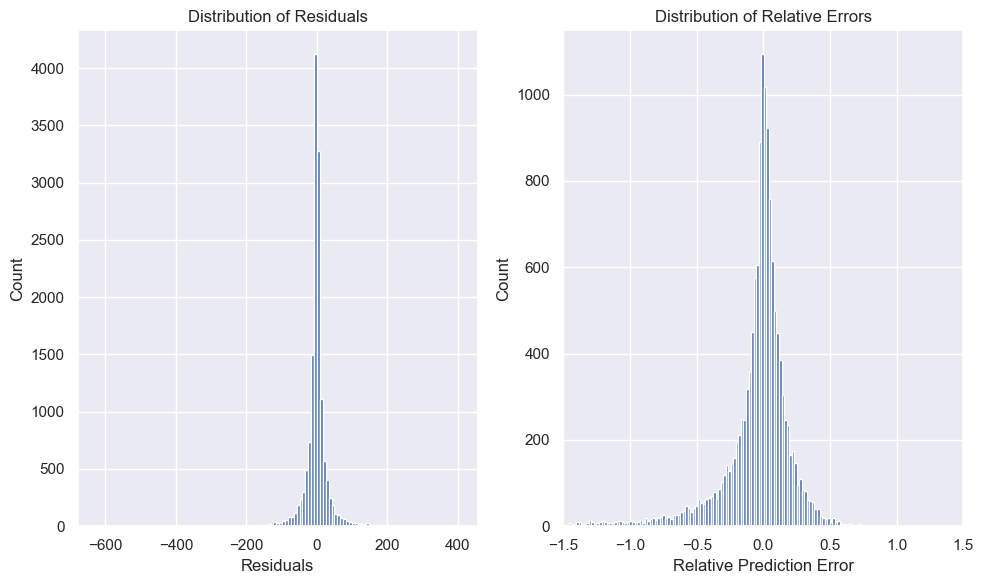

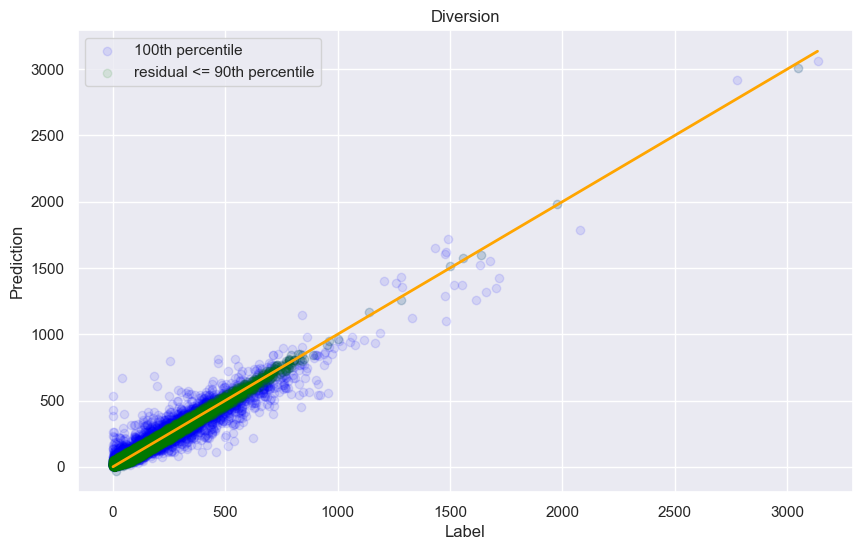

AttributeError: 'LGBMRegressor' object has no attribute 'evals_result'

In [92]:
best_params = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'n_estimators': 1500,
    # 'lambda_l1': 85.2846485612467,
    # 'lambda_l2': 4.628825755802762,
    # 'num_leaves': 1021,
    # # 'feature_fraction': 0.668370377660226,
    # # 'bagging_fraction': 0.8886019976321862,
    # # 'bagging_freq': 1,
    # 'min_child_samples': 5
    'lambda_l1': 3.6018619654574158,
    'lambda_l2': 6.8313158663780085,
    'num_leaves': 1949,
    'feature_fraction': 0.7141755393339907,
    'bagging_fraction': 0.9475392738527537,
    'bagging_freq': 7,
    'min_child_samples': 7}
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

# Assuming combined_train_data, y03_train, combined_val_data, y03_val are already defined

# Create the LightGBM regressor with the best hyperparameters
model = lgb.LGBMRegressor(**best_params)

# Fit the model on the training data
model.fit(
    combined_train_data, y03_train,
    eval_set=[(combined_val_data, y03_val)],
    eval_metric='mae',
    callbacks=[early_stopping(stopping_rounds=5)]
)

# Make predictions on the validation set
y_preds = model.predict(combined_val_data)

# Evaluate the model
mae = mean_absolute_error(y03_val, y_preds)
rmse = mean_squared_error(y03_val, y_preds, squared=False)
r2 = r2_score(y03_val, y_preds)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

evaluation_plot(model,y03_val, y_preds)

# combined_data = np.concatenate([feature_extraction_model.predict(pictures), X03], axis=1)
# cv_scores = cross_val_score(gbm, combined_data, y03, cv=10, scoring='neg_mean_absolute_error')

# print("Cross-Validation: %.4f +- %.4f" % (-cv_scores.mean(), cv_scores.std()))

In [94]:
# combined_data = np.concatenate([feature_extraction_model.predict(pictures), X03], axis=1)
# cv_scores = cross_val_score(model, combined_data, y03, cv=5, scoring='neg_mean_absolute_error')
# cv_scores = cross_val_score(model, combined_val_data, y03_val, cv=5, scoring='neg_mean_absolute_error')
cv_scores = cross_val_score(model, combined_train_data, y03_train, cv=5, scoring='neg_mean_absolute_error')

# combined_val_data
print("Cross-Validation: %.4f +- %.4f" % (-cv_scores.mean(), cv_scores.std()))

Cross-Validation: 21.5735 +- 0.3625


In [95]:
cv_scores

array([-22.0903021 , -21.91127449, -21.40467226, -21.30832611,
       -21.15286699])

In [328]:
%%time
metadata_file2 = "n0_metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv"
glathida_rgis2 = pd.read_csv(metadata_file2, low_memory=False)
# glathida_rgis2 = glathida_rgis2.dropna()
print(np.shape(pictures))
print(np.shape(glathida_rgis2))
test = []
for i in range(len(pictures)):
    test.append(pictures[i].flatten())
# glathida_rgis2['PICTURE'] = test
# glathida_rgis2.to_csv('n0_wpics_metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv', index=False)

(73111, 64, 64)
(73111, 59)
CPU times: total: 11.9 s
Wall time: 13.5 s


In [ ]:
# create a study and start the optimization process:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [62]:
def test_overfitting(estimator, score_func, X_train, y_train, X_test, y_test, prob=False):
    # input: score_func = function, like mean_absolute_error for regression
    # input: prob = bool, to use either probability prediction or number/discrete prediction for score function
    # checked 19/05/2024

    if prob:
        y_pred_train = estimator.predict_proba(X_train)
        y_pred_test = estimator.predict_proba(X_test)
    else:        
        y_pred_train = estimator.predict(X_train)
        y_pred_test = estimator.predict(X_test)
    
    accuracy_train = score_func(y_train, y_pred_train)
    accuracy_test = score_func(y_test, y_pred_test)
    
    print(f"Training Accuracy: {accuracy_train:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")
    
def evaluation_plot(estimator, y_test, y_pred):
    # input: estimator = xgb_cl - XGBClassifier with all the hyperparameter, for example
    # input: y_test = we divided our y (labeled feature we want to know) into train, test, validation, y_test is the part from test 
    # input: y_pred = is the y values predicted for the X_test
    # plot the figures from the feedback document of the inital project in applied machine learning 2024 
    # (Diversion, Distribution Residuals and Relative Errors)
    # checked 04/06/2024

    y_test = np.array(y_test) 
    residuals = y_test - y_pred
    relative_errors = residuals / np.abs(y_test)
    relative_errors = relative_errors[np.abs(relative_errors) <= 1.5]
    percentile_90 = np.percentile(np.abs(residuals), 90)
    high_residual_mask = np.abs(residuals) <= percentile_90

    # Plot the Distribution of the Residuals and the Relative Errors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.hist(residuals, bins=125)
    ax1.set_title('Distribution of Residuals')
    ax1.set_xlabel('Residuals')
    ax1.set_ylabel('Count')
    #ax1.set_xlim()
    
    ax2.hist(relative_errors, bins=125)
    ax2.set_title('Distribution of Relative Errors')
    ax2.set_xlabel('Relative Prediction Error')
    ax2.set_ylabel('Count')
    ax2.set_xlim(-1.5, 1.5)
    plt.tight_layout()
    plt.show()
    
    # Plot the Diversion
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, c='blue', alpha=0.1, label='100th percentile')
    plt.scatter(y_test[high_residual_mask], y_pred[high_residual_mask], c='green', alpha=0.1, label='residual <= 90th percentile')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linewidth=2)
    # plt.ylim((0,1250))
    # plt.xlim((0,1250))
    
    plt.xlabel('Label')
    plt.ylabel('Prediction')
    plt.title('Diversion')
    plt.legend()
    plt.show()

    # Plot the RMSE for training and validation sets
    results = estimator.evals_result()
    epochs = len(results['validation_0']['mae'])
    x_axis = range(0, epochs)

    # Plot RMSE and MAE metric
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax1.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax1.plot(x_axis, results['validation_2']['rmse'], label='Validation')
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('RMSE')
    ax1.set_title('Evolution of the Root Mean Squared Error')

    ax2.plot(x_axis, results['validation_0']['mae'], label='Train')
    ax2.plot(x_axis, results['validation_1']['mae'], label='Test')
    ax2.plot(x_axis, results['validation_2']['mae'], label='Validation')
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.set_title('Evolution of the Mean Absolute Error')
    plt.tight_layout()
    plt.show()

In [136]:
evaluation_plot(model,y03_val, y_preds)


AttributeError: 'LGBMRegressor' object has no attribute 'evals_result'

In [255]:
stupid = glathida_rgis[glathida_rgis['THICKNESS'] >= 1000]
len(np.unique(stupid['RGIId']))

25

In [257]:
metadata_file2 = "metadata19_hmineq0.0_tmin20050000_mean_grid_100.csv"
glathida_rgis2 = pd.read_csv(metadata_file2, low_memory=False)
stupid = glathida_rgis2[glathida_rgis2['THICKNESS'] >= 1000]
len(np.unique(stupid['RGIId']))

33